# Machine Learning Pipeline - Model Training

In this notebook, we pick up the transformed datasets and the selected variables that we saved in the previous notebooks.

# Reproducibility: Setting the seed

With the aim to ensure reproducibility between runs of the same notebook, but also between the research and production environment, for each step that includes some element of randomness, it is extremely important that we **set the seed**.

/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
## **I. Carga de librerias**
/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [1]:
# to handle datasets
import pandas as pd
import numpy as np

# for plotting
import matplotlib.pyplot as plt

# to save the model
import joblib

# to build the model
from sklearn.linear_model import Lasso

# to evaluate the model
from sklearn.metrics import mean_squared_error, r2_score

# to visualise al the columns in the dataframe
pd.pandas.set_option('display.max_columns', None)

/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
## **II. Carga de Dataset de Datos**
/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [2]:
# load the train and test set with the engineered variables

# we built and saved these datasets in a previous notebook.
# If you haven't done so, go ahead and check the previous notebooks (step 2)
# to find out how to create these datasets

X_train = pd.read_csv('./Output/xtrain.csv')
X_test = pd.read_csv('./Output/xtest.csv')

X_train.head()

,C3S,Retenido M450,Fraguado final,Superficie específica,CaCO3,Retenido M325,Yeso,Expansión en autoclave,Fe2O3,Na2O,Polvo Filtro,MgO,SO3,Cal Libre,Fluidez
0,0.475299,0.722222,0.500000,0.465517,0.236599,0.500000,0.538462,0.0,0.480769,0.727273,0.0,0.666667,0.500000,0.666667,0.000000
1,0.155486,0.666667,0.357143,0.793103,0.683919,1.000000,0.250000,0.0,0.173077,0.454545,0.0,0.333333,0.452381,0.000000,0.285714
2,0.165367,0.611111,0.785714,0.655172,0.451017,0.500000,0.826923,0.0,0.519231,0.636364,0.0,0.333333,0.571429,0.666667,0.714286
3,0.520541,0.388889,0.142857,0.482759,0.421442,0.500000,0.288462,0.0,0.538462,0.454545,0.0,0.333333,0.476190,1.000000,0.142857
4,0.421737,0.444444,0.571429,0.698276,0.255083,0.666667,0.548077,0.5,0.480769,0.636364,0.0,0.666667,0.238095,0.000000,0.428571


In [3]:
# load the target (remember that the target is log transformed)
y_train = pd.read_csv('./Output/ytrain.csv')
y_test = pd.read_csv('./Output/ytest.csv')

y_train.head()

,RC 1 día
0,7.251345
1,7.244228
2,7.265430
3,7.565275
4,7.170120


In [11]:
np.exp(y_test)

,RC 1 día
0,1550.0
1,1880.0
2,1350.0
3,1460.0
4,1380.0
...,...
89,1850.0
90,1450.0
91,1690.0
92,1900.0


/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
## **III. Procesamiento, tratamiento y preparación de Datos**
/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

In [14]:
import statsmodels.api as sm
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

#====================================================================================================================
#Función para ajustar el modelo OLS y eliminar variables con p-value > 0.05
#====================================================================================================================
def backward_elimination(X, y, significance_level=0.05, variables_a_mantener=None):
    if variables_a_mantener is None:
        variables_a_mantener = []  # 'Clínker I Total' # Inicializar como lista vacía si no se proporciona ninguna
    #====================================================================================================================
    # Agregar constante (intersección) al conjunto de variables predictoras
    #====================================================================================================================
    X_with_const = sm.add_constant(X)
    #====================================================================================================================
    # Ajustar el modelo inicial
    #====================================================================================================================
    ols_model = sm.OLS(y, X_with_const).fit()
    #====================================================================================================================
    # Iterar hasta que todas las variables tengan un p-value <= 0.05
    #====================================================================================================================
    while max(ols_model.pvalues) > significance_level:
        # Identificar la variable con el p-value más alto
        worst_pvalue_var = ols_model.pvalues.idxmax()
        #====================================================================================================================
        # Si la constante tiene un p-value mayor a 0.05, romper el bucle
        #====================================================================================================================
        if worst_pvalue_var == 'const':
            break
        #====================================================================================================================
        # Verificar si la variable está en la lista de variables a mantener
        #====================================================================================================================
        if worst_pvalue_var in variables_a_mantener:
            print(f"Reteniendo {worst_pvalue_var} a pesar de su p-value: {ols_model.pvalues[worst_pvalue_var]}")
            break  # Salimos del bucle porque no se debe eliminar ninguna variable más protegida.
        #====================================================================================================================
        # Eliminar la variable con el peor p-value
        #====================================================================================================================
        print(f"Eliminando {worst_pvalue_var} con p-value: {ols_model.pvalues[worst_pvalue_var]}")
        X_with_const = X_with_const.drop(columns=[worst_pvalue_var])
        #====================================================================================================================
        # Reajustar el modelo sin esa variable
        #====================================================================================================================
        ols_model = sm.OLS(y, X_with_const).fit()

    return ols_model

#====================================================================================================================
# # Ejemplo de uso: Mantener ciertas variables
#====================================================================================================================
#
variables_a_mantener =[] # 'Superficie específica','Retenido M325','Fraguado final','Clínker I Total'
ols_model_final = backward_elimination(X_train, y_train, significance_level=0.05, variables_a_mantener=variables_a_mantener)
#====================================================================================================================
# Resumen del modelo final
#====================================================================================================================
print(ols_model_final.summary())

#====================================================================================================================
# Predicciones en el conjunto de entrenamiento y prueba
#====================================================================================================================
X_train_const_final = sm.add_constant(X_train[ols_model_final.model.exog_names[1:]])  # Mantener solo las variables seleccionadas
X_test_const_final = sm.add_constant(X_test[ols_model_final.model.exog_names[1:]])

y_train_pred_ols = ols_model_final.predict(X_train_const_final)
y_test_pred_ols = ols_model_final.predict(X_test_const_final)

#====================================================================================================================
# Evaluación del modelo en entrenamiento y prueba
#====================================================================================================================
rmse_train_ols = np.sqrt(mean_squared_error(y_train, y_train_pred_ols))
rmse_test_ols = np.sqrt(mean_squared_error(y_test, y_test_pred_ols))
r2_train_ols = r2_score(y_train, y_train_pred_ols)
r2_test_ols = r2_score(y_test, y_test_pred_ols)

#====================================================================================================================
# Resultados del modelo OLS con selección por p-value
#====================================================================================================================
results_ols = pd.DataFrame({
    "Model": ["OLS Regression (p-value ≤ 0.05)"],
    "RMSE Train": [rmse_train_ols],
    "RMSE Test": [rmse_test_ols],
    "R² Train": [r2_train_ols],
    "R² Test": [r2_test_ols]
})

print(results_ols)

# #====================================================================================================================
# # Gráfico de residuos
# #====================================================================================================================
# plt.scatter(y_test_pred_ols, y_test - y_test_pred_ols, alpha=0.5)
# plt.title('Gráfico de residuos - OLS (p-value ≤ 0.05)')
# plt.xlabel('Predicciones')
# plt.ylabel('Residuos')
# plt.axhline(0, color='red', linestyle='--')
# plt.show()
# #====================================================================================================================
# # Gráfico de importancia de variables (coeficientes)
# #====================================================================================================================
# coefs = pd.Series(ols_model_final.params[1:], index=ols_model_final.model.exog_names[1:]).sort_values()
# coefs.plot(kind='barh')
# plt.title("Importancia de las variables (coeficientes OLS)")
# plt.show()

Eliminando Retenido M325 con p-value: 0.35916760102599576
                            OLS Regression Results                            
Dep. Variable:               RC 1 día   R-squared:                       0.842
Model:                            OLS   Adj. R-squared:                  0.838
Method:                 Least Squares   F-statistic:                     214.3
Date:                Thu, 13 Mar 2025   Prob (F-statistic):          3.80e-139
Time:                        18:54:30   Log-Likelihood:                 549.51
No. Observations:                 372   AIC:                            -1079.
Df Residuals:                     362   BIC:                            -1040.
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------

In [ ]:
y_train_pred_ols = ols_model_final.predict(X_train_const_final)
y_test_pred_ols = ols_model_final.predict(X_test_const_final)
# y_val_pred_ols = ols_model_final.predict(X_val_const_final)
# y_val_pred_ols.shape, y_val.shape

In [15]:
# Evaluación del modelo en entrenamiento y prueba
rmse_train_ols = np.sqrt(mean_squared_error(np.exp(y_train), np.exp(y_train_pred_ols)))
rmse_test_ols = np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_test_pred_ols)))
#rmse_val_ols = np.sqrt(mean_squared_error(np.exp(y_val), np.exp(y_val_pred_ols)))
r2_train_ols = r2_score(np.exp(y_train), np.exp(y_train_pred_ols))
r2_test_ols = r2_score(np.exp(y_test), np.exp(y_test_pred_ols))
#r2_val_ols = r2_score(np.exp(y_val), np.exp(y_val_pred_ols))

results_ols = pd.DataFrame({
    "Model": ["OLS Regression (p-value ≤ 0.05)"],
    "RMSE Train": [rmse_train_ols],
    "RMSE Test": [rmse_test_ols],
    #"RMSE Val": [rmse_val_ols],
    "R² Train": [r2_train_ols],
    "R² Test": [r2_test_ols],
    #"R² Val": [r2_val_ols]
})

print(results_ols)

                             Model  RMSE Train  RMSE Test  R² Train   R² Test
0  OLS Regression (p-value ≤ 0.05)   83.968857  87.732252  0.849619  0.848688


Los resultados muestran que los resultados entre los datos de Train y Test mantienen un performance entre el R2 y el RMSE

In [4]:
# Cargamos las características pre-seleccionadas
# ==============================

# we selected the features in the previous notebook (step 3)

# if you haven't done so, go ahead and visit the previous notebook
# to find out how to select the features

features = pd.read_csv('./Output/selected_features.csv')
features = features['0'].to_list() 

# display final feature set
features

['C3S',
 'Retenido M450',
 'Fraguado final',
 'Superficie específica',
 'Retenido M325',
 'Yeso',
 'Expansión en autoclave',
 'Polvo Filtro',
 'SO3',
 'Cal Libre']

In [5]:
# reduce the train and test set to the selected features

X_train = X_train[features]
X_test = X_test[features]

/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////
## **IV. Construcción de modelos predictivos de Regresion**
/////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////////

### Regularised linear regression: Lasso

Remember to set the seed.

In [6]:
# Configurar el modelo
# remember to set the random_state / seed

lin_model = Lasso(alpha=0.001, random_state=0)

# train the model

lin_model.fit(X_train, y_train)

Lasso(alpha=0.001, random_state=0)

In [7]:
# evaluate the model:
# ====================

# remember that we log transformed the output (SalePrice)
# in our feature engineering notebook (step 2).

# In order to get the true performance of the Lasso
# we need to transform both the target and the predictions
# back to the original house prices values.

# Evaluaremos el performance usando Mean Squared Error y
# the root of the mean squared error and r2

# make predictions for train set
pred = lin_model.predict(X_train)

# determine mse, rmse and r2
print('train mse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred)))))
print('train rmse: {}'.format(int(
    mean_squared_error(np.exp(y_train), np.exp(pred), squared=False))))
print('train r2: {}'.format(
    r2_score(np.exp(y_train), np.exp(pred))))
print()

# INFERENCIA
# make predictions for test set
pred = lin_model.predict(X_test)

# determine mse, rmse and r2
print('test mse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred)))))
print('test rmse: {}'.format(int(
    mean_squared_error(np.exp(y_test), np.exp(pred), squared=False))))
print('test r2: {}'.format(
    r2_score(np.exp(y_test), np.exp(pred))))
print()

print('Average house price: ', int(np.exp(y_train).median()))

train mse: 7633
train rmse: 87
train r2: 0.8419569527084013

test mse: 9178
test rmse: 95
test r2: 0.8034788743373309

Average house price:  1429


c:\Users\enriq\anaconda3\envs\DataPat-MLOps-11\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
c:\Users\enriq\anaconda3\envs\DataPat-MLOps-11\lib\site-packages\sklearn\metrics\_regression.py:483: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\enriq\AppData\Local\Temp\ipykernel_17572\551199674.py:39: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  print('Average house price: ', int(np.exp(y_train).median()))


Text(0.5, 1.0, 'Evaluation of Lasso Predictions')

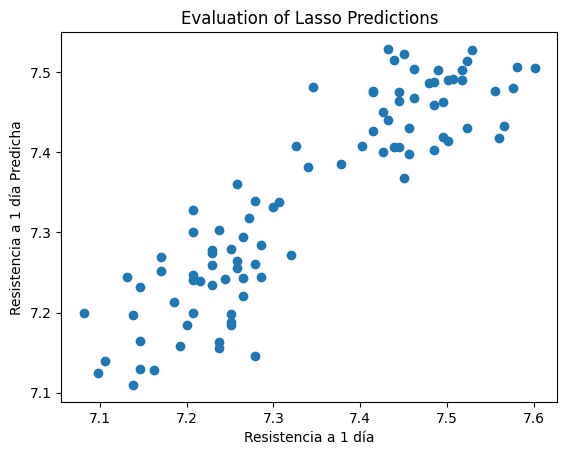

In [9]:
# let's evaluate our predictions respect to the real sale price
plt.scatter(y_test, lin_model.predict(X_test))
plt.xlabel('Resistencia a 1 día')
plt.ylabel('Resistencia a 1 día Predicha')
plt.title('Evaluation of Lasso Predictions')

Podemos ver que nuestro modelo está haciendo un muy buen trabajo estimando los Resistencia a 1 día.

In [10]:
y_test.reset_index(drop=True)

,RC 1 día
0,7.229839
1,7.237059
2,7.489971
3,7.506592
4,7.207860
...,...
87,7.279319
88,7.484369
89,7.170120
90,7.258412


In [11]:
# evaluemos la distribución de los errores:
# deberían estar distribuidos de manera bastante normal

y_test.reset_index(drop=True, inplace=True)

preds = pd.Series(lin_model.predict(X_test))

preds

0     7.259697
1     7.155318
2     7.503085
3     7.491694
4     7.246763
        ...   
87    7.261158
88    7.402364
89    7.252405
90    7.360826
91    7.243061
Length: 92, dtype: float64

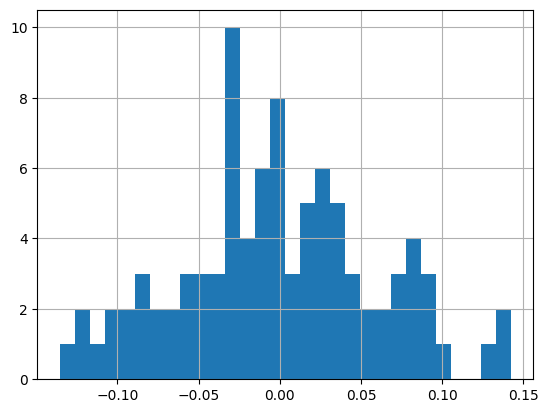

In [12]:
# evaluemos la distribución de los errores:
# deberían estar distribuidos de manera bastante normal

errors = y_test['RC 1 día'] - preds
errors.hist(bins=30)
plt.show()

La distribución de los errores sigue bastante de cerca una distribución gaussiana. Esto sugiere que nuestro modelo también está haciendo un buen trabajo.

### Feature importance

Text(0.5, 1.0, 'Feature Importance')

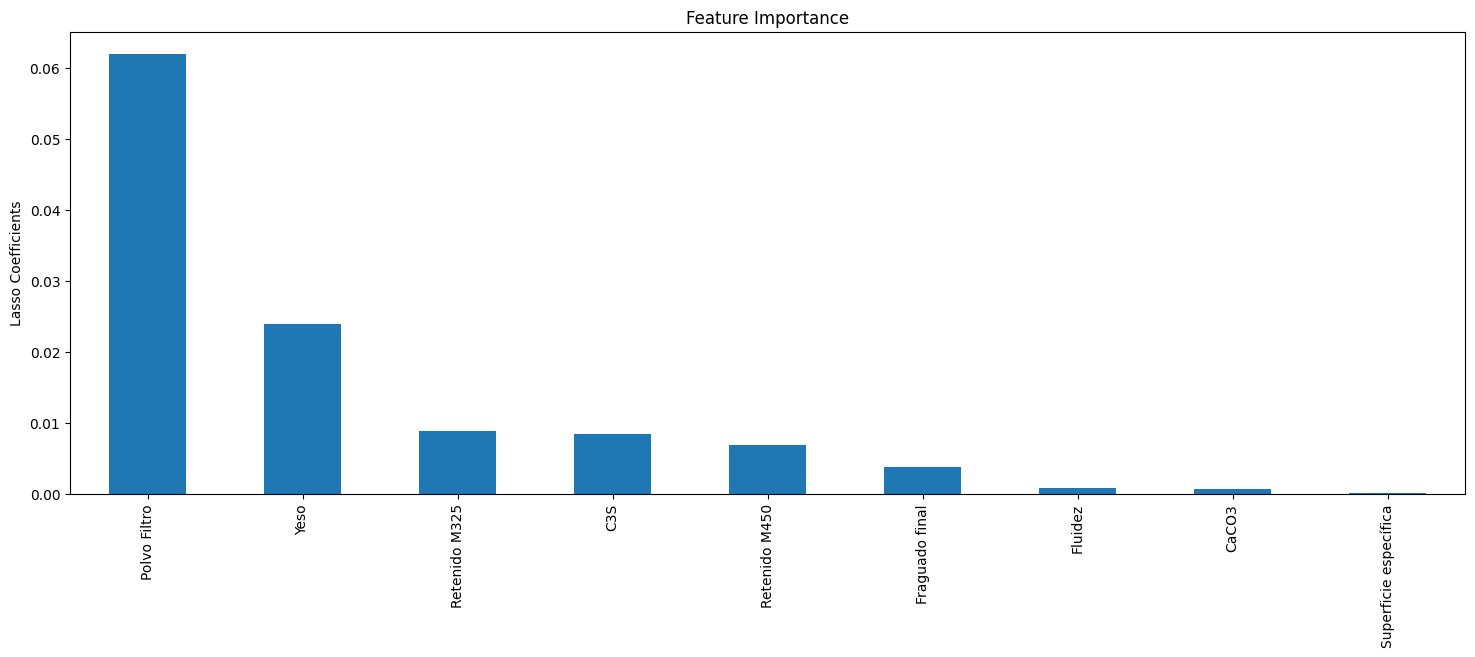

In [13]:
# Finalmente, solo por diversión, veamos la importancia de las características.

importance = pd.Series(np.abs(lin_model.coef_.ravel()))
importance.index = features
importance.sort_values(inplace=True, ascending=False)
importance.plot.bar(figsize=(18,6))
plt.ylabel('Lasso Coefficients')
plt.title('Feature Importance')

## Save the Model

In [15]:
# estamos contentos con nuestro modelo, así que lo guardamos
# para poder evaluar nuevos datos

joblib.dump(lin_model, './Output/linear_regression_R1.joblib') 

['./Output/linear_regression_R1.joblib']

In [16]:
Data_train = pd.DataFrame(X_train)
Data_train['RC 1 día'] = y_train
Data_train.head(3)

,C3S,Retenido M450,Fraguado final,Superficie específica,CaCO3,Retenido M325,Yeso,Polvo Filtro,Fluidez,RC 1 día
0,21.94,10.0,280.0,6120.0,20.19,2.8,4.60,0.0,106.0,7.029973
1,23.86,9.2,280.0,6180.0,19.78,2.4,4.45,0.0,106.0,7.244228
2,32.54,7.6,245.0,5240.0,18.16,2.0,4.50,0.0,110.0,7.506592


In [17]:
Data_train.to_csv("Data_train.csv", index = False)